<a href="https://colab.research.google.com/github/HWMV/AIFFEL_Quest1/blob/master/Project/dogNcat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog & Cat Classification
## VGG16 model 활용
## AIFFEL 온라이 6기 최현우

In [128]:
# import
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [129]:
# data load
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [130]:
# train, validation data dir
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')
print(train_dir)
print(validation_dir)

/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/validation


In [131]:
# cat, dog data dir
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
print(train_cats_dir)

# directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
print(train_dogs_dir)

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
print(validation_cats_dir)

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print(validation_dogs_dir)

/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs


In [132]:
# 각 data num Check
num_cats_tr = len(os.listdir(train_cats_dir))
print('total training cat images:', num_cats_tr)
num_dogs_tr = len(os.listdir(train_dogs_dir))
print('total training dog images:', num_dogs_tr)

print("--")

num_cats_val = len(os.listdir(validation_cats_dir))
print('total validation cat images:', num_cats_val)
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('total validation dog images:', num_dogs_val)

print("--")

total_train = num_cats_tr + num_dogs_tr
print("Total training images:", total_train)
total_val = num_cats_val + num_dogs_val
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
--
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [133]:
# parameter Initialization
batch_size = 16
epochs = 15
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [134]:
# data Visualation fucntion

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [135]:
# Data Augmentation (데이터 증강, train 수가 너무 적음 )
# Training data generator

image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.3,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=False)

In [136]:
# 변수.flow_from_directory를 사용해서 파이프라인과 dir와 작업 환경 연결

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary') # 이진분류 이기에..

Found 2000 images belonging to 2 classes.


In [137]:
# Data Augmentation Check
train_data_gen[0][0].shape

(16, 256, 256, 3)

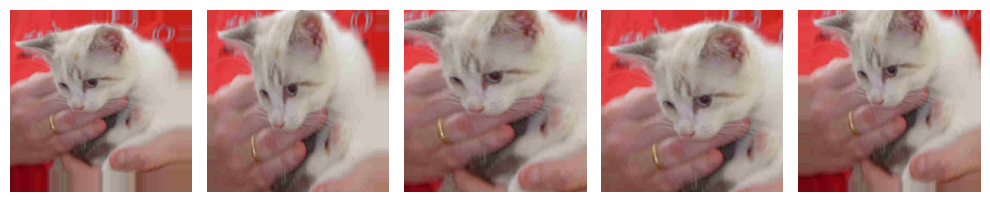

In [138]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [139]:
# Validation data generator
# train과 동일한 작업이지만 평가용도로만 사용할 것이라 스케일만 변경 해줍니다
# train 처럼 섞고 돌리고 늘리고 줄이고 안한다는 소리!
image_gen_val = ImageDataGenerator(rescale=1./255)

In [140]:
# .flow_from_directory (증강 적용)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


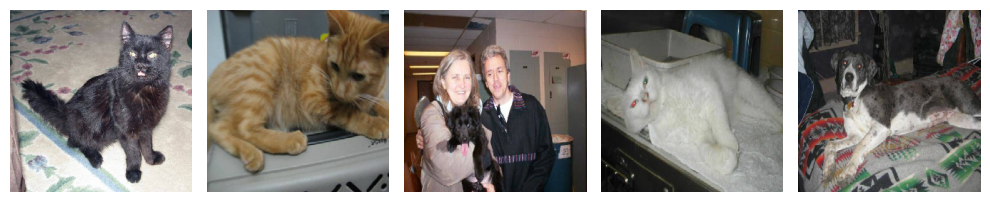

In [141]:
# val_data 평가 시각화 5장
sample_training_images, _ = next(val_data_gen)
plotImages(sample_training_images[:5])

In [142]:
_[:5] # 정답 데이터 개, 개, 고양, 고양, 개

array([0., 0., 1., 0., 1.], dtype=float32)

## 2. VGG 16 model 구현

In [143]:
# pre-trained model 활용하기
from tensorflow.keras.applications import VGG16

# pre-trained model freeze part
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

base_model.trainable = False
# False는 pre-trained 전체 freeze
# True는 freeze 해제
# pre-trained model layer 확인
for layer in base_model.layers:
    print(layer.name, layer.output_shape)

# input layer
input_layer = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# VGG16 pre-trained model 활용
x = base_model.output

# FC Layer
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)

model.summary()


input_75 [(None, 256, 256, 3)]
block1_conv1 (None, 256, 256, 64)
block1_conv2 (None, 256, 256, 64)
block1_pool (None, 128, 128, 64)
block2_conv1 (None, 128, 128, 128)
block2_conv2 (None, 128, 128, 128)
block2_pool (None, 64, 64, 128)
block3_conv1 (None, 64, 64, 256)
block3_conv2 (None, 64, 64, 256)
block3_conv3 (None, 64, 64, 256)
block3_pool (None, 32, 32, 256)
block4_conv1 (None, 32, 32, 512)
block4_conv2 (None, 32, 32, 512)
block4_conv3 (None, 32, 32, 512)
block4_pool (None, 16, 16, 512)
block5_conv1 (None, 16, 16, 512)
block5_conv2 (None, 16, 16, 512)
block5_conv3 (None, 16, 16, 512)
block5_pool (None, 8, 8, 512)
Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_75 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                           

# freeze, train 비중 조절하다가 실패.. 나중에 다시 해보기

In [144]:
# freeze, train 비중 조절하다가 실패.. 나중에 다시 해보기

# from tensorflow.python.ops.parallel_for.pfor import xla
# # pre-trained model 활용하기
# from tensorflow.keras.applications import VGG16

# # pre-trained model freeze part
# base_model = VGG16(weights='imagenet',
#                    include_top=False,
#                    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# base_model.trainable = False
# # False는 pre-trained 전체 freeze
# # True는 freeze 해제
# # pre-trained model layer 확인
# for layer in base_model.layers:
#     print(layer.name, layer.output_shape)

# # input layer
# input_layer = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# # global feature map 추출을 위한 추가 레이어
# x = tf.keras.layers.Conv2D(3, (3, 3), activation='relu',padding='same')(input_layer)
# x = tf.keras.layers.BatchNormalization()(x)

# input_layer = x

# # VGG16 pre-trained model 활용
# x = base_model(x)

# # FC Layer
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(512, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# model = tf.keras.Model(inputs=base_model.input, outputs=x)

# model.summary()


In [145]:
# Lossfunction, optimizer, metric 설정
# compile 조건 설정
loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=0.01)
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

callbacks_list= [tf.keras.callbacks.TensorBoard(log_dir='log_dir', histogram_freq=1)]
# callback 함수를 활용하고 싶다면 추가해서 학습하는 데에 활용해 보세요.

In [146]:
# earlystopping 과 lrs 적용해보자
# lrs는 처음 Conv에서 꼼꼼하게 살피면서 학습률을 작 > 크
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Early Stopping Callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Learning Rate Scheduler
def learning_rate_scheduler(epoch, learning_rate):
    if epoch <= 5:
        return learning_rate * 0.5
    else:
        return learning_rate

lr_scheduler_callback = LearningRateScheduler(learning_rate_scheduler)


In [149]:
# model fit
history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      callbacks=[early_stopping_callback, lr_scheduler_callback,callbacks_list],
      validation_freq=1)

Epoch 1/15
125/125 [==============================] - 35s 268ms/step - loss: 3.3424 - binary_accuracy: 0.7575 - val_loss: 0.2529 - val_binary_accuracy: 0.8990 - lr: 0.0050
Epoch 2/15
125/125 [==============================] - 34s 272ms/step - loss: 0.3373 - binary_accuracy: 0.8585 - val_loss: 0.2327 - val_binary_accuracy: 0.9000 - lr: 0.0025
Epoch 3/15
125/125 [==============================] - 34s 273ms/step - loss: 0.2794 - binary_accuracy: 0.8825 - val_loss: 0.2166 - val_binary_accuracy: 0.9110 - lr: 0.0012
Epoch 4/15
125/125 [==============================] - 34s 272ms/step - loss: 0.2441 - binary_accuracy: 0.8880 - val_loss: 0.1988 - val_binary_accuracy: 0.9160 - lr: 6.2500e-04
Epoch 5/15
125/125 [==============================] - 34s 275ms/step - loss: 0.2390 - binary_accuracy: 0.9035 - val_loss: 0.1992 - val_binary_accuracy: 0.9160 - lr: 3.1250e-04
Epoch 6/15
125/125 [==============================] - 34s 275ms/step - loss: 0.2216 - binary_accuracy: 0.9105 - val_loss: 0.1952 - v

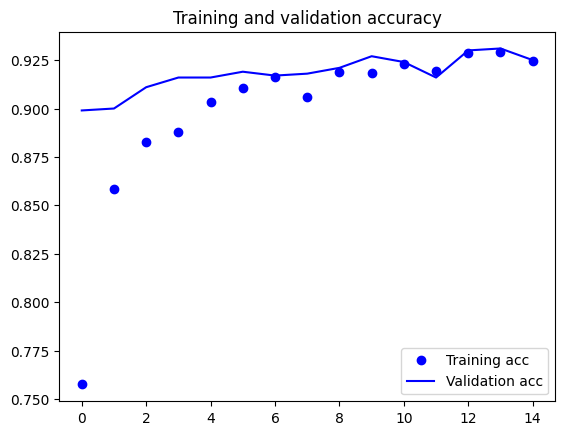

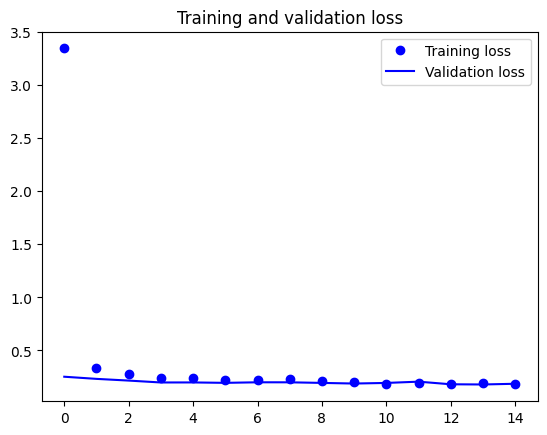

In [150]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 3. 평가

In [151]:
# model.evaluate()

model.evaluate(val_data_gen)

63/63 [==============================] - 5s 81ms/step - loss: 0.1867 - binary_accuracy: 0.9250


[0.18667155504226685, 0.925000011920929]

# 회고록

* pre-trained model 로 VGG16을 활용하였고, freeze, train 부분 조절해서 학습 해보려 하였으나 실패 하였습니다

* lrScheduler와 earlystopping 등 callback 함수를 사용하여 pre-trained 모델에서 2.5% 향상 시켰습니다
